<a href="https://colab.research.google.com/github/Kenton-Tang-HK/Portfolio_Optimization/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Create a Portfolio

In [2]:
# Define a list of stock symbols you want to include in the portfolio
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Define the date range for historical data
start_date = '2010-01-01'
end_date = '2022-12-31'

# Fetch historical data for the selected stocks
portfolio_data = yf.download(stock_symbols, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = portfolio_data.pct_change().dropna()

# Fetch the 10-year Treasury yield as the risk-free rate (^IRX)
risk_free_data = yf.download('^IRX', start=start_date, end=end_date)['Adj Close']
risk_free_rate = risk_free_data.mean() / 100.0  # Convert to decimal

# Calculate mean returns and covariance matrix
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


Maximise Sharpe Ratio

In [3]:
# Define functions for portfolio statistics
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    port_returns = np.sum(mean_returns * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (port_returns - risk_free_rate) / port_volatility
    return port_returns, port_volatility, sharpe_ratio

# Define the objective function for optimization (Maximize Sharpe Ratio)
def objective_function(weights, mean_returns, cov_matrix):
    port_returns, port_volatility, sharpe_ratio = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -sharpe_ratio

# Define constraints for optimization (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define the bounds for each stock weight (0 to 1)
bounds = tuple((0, 1) for _ in range(len(stock_symbols)))

# Initialize an equal weight portfolio as a starting point
initial_weights = [1 / len(stock_symbols)] * len(stock_symbols)

# Perform the optimization to maximize the Sharpe Ratio
optimal_weights = minimize(objective_function, initial_weights, args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimized portfolio weights
optimized_weights = optimal_weights.x

# Calculate portfolio statistics for the optimized portfolio
optimal_returns, optimal_volatility, optimal_sharpe_ratio = portfolio_annualized_performance(
    optimized_weights, mean_returns, cov_matrix)

# Print the optimized portfolio weights and statistics
print("Optimal Portfolio Weights:")
for symbol, weight in zip(stock_symbols, optimized_weights):
    print(f"{symbol}: {weight:.2%}")

print("\nOptimal Portfolio Statistics:")
print(f"Expected Annual Returns: {optimal_returns:.2%}")
print(f"Annual Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Portfolio Weights:
AAPL: 32.28%
MSFT: 16.20%
GOOGL: 0.00%
AMZN: 29.93%
TSLA: 21.58%

Optimal Portfolio Statistics:
Expected Annual Returns: 31.26%
Annual Volatility: 26.51%
Sharpe Ratio: 1.1564


Visualize Efficient Frontier

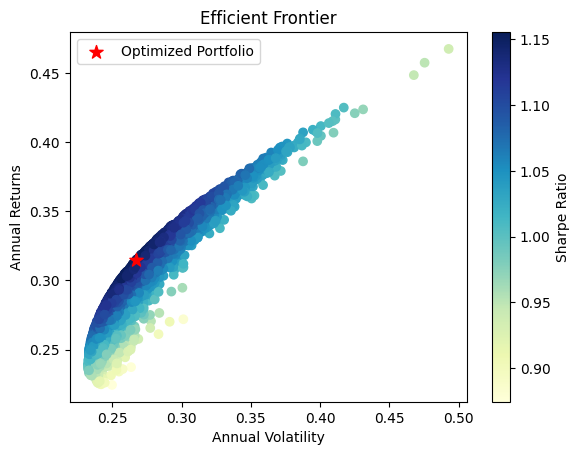

In [4]:
# Visualize the efficient frontier
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)
    portfolio_return, portfolio_std_dev, portfolio_sharpe = portfolio_annualized_performance(
        weights, mean_returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    results[2, i] = portfolio_sharpe

# Scatter plot for efficient frontier
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu')
plt.title('Efficient Frontier')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Returns')
plt.colorbar(label='Sharpe Ratio')

# Locate and highlight the optimized portfolio
max_sharpe_idx = np.argmax(results[2])
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], c='red', marker='*', s=100, label='Optimized Portfolio')

plt.legend()
plt.show()